In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Выбор локации для скважины

Нам предоставленны данные по трем регионам нефтедобычи, в каждом по 10 тыс. месторождений с определенными объемами нефти.

Требуется предсказать регион с наибольшей прибылью.

Найти: достаточный объём сырья для безубыточной разработки новой скважины; прибыль для полученного объёма сырья; риски разработки месторождения(до 2.5%) опираясь на выделенный бюджет в 10 млрд и доход у.е. в 450 тыс.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import seaborn  as sns
import numpy as np
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
data0 = pd.read_csv('/content/drive/MyDrive/geo_data_0.csv')
data1 = pd.read_csv('/content/drive/MyDrive/geo_data_1.csv')
data2 = pd.read_csv('/content/drive/MyDrive/geo_data_2.csv')

In [4]:
data0.info()
data0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data1.info()
data1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data2.info()
data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
data0.duplicated().sum() , data1.duplicated().sum() , data2.duplicated().sum()

(0, 0, 0)

In [8]:
data0.nunique(), data1.nunique(), data2.nunique(),

(id          99990
 f0         100000
 f1         100000
 f2         100000
 product    100000
 dtype: int64,
 id          99996
 f0         100000
 f1         100000
 f2         100000
 product        12
 dtype: int64,
 id          99996
 f0         100000
 f1         100000
 f2         100000
 product    100000
 dtype: int64)

Пропусков и дубликатов не найдено.

Во втором датасете всего 12 уникальных признаков объема

In [9]:
data0 = data0.drop(['id'], axis = 1)
data1 = data1.drop(['id'], axis = 1)
data2 = data2.drop(['id'], axis = 1)

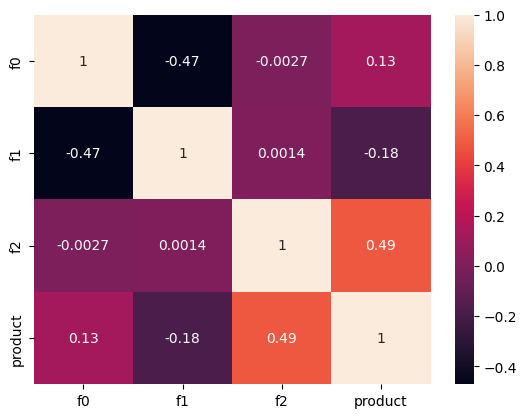

In [10]:
sns.heatmap(data0.corr(method = 'spearman'), annot = True);

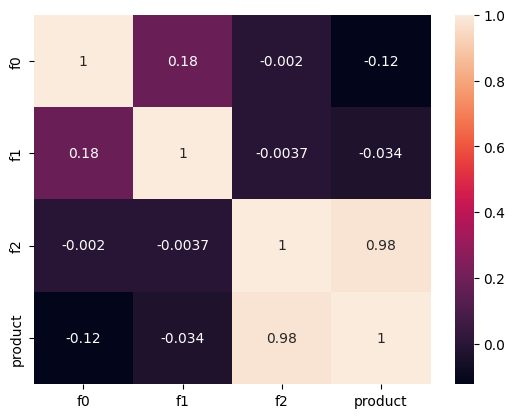

In [11]:
sns.heatmap(data1.corr(method = "spearman"), annot = True);

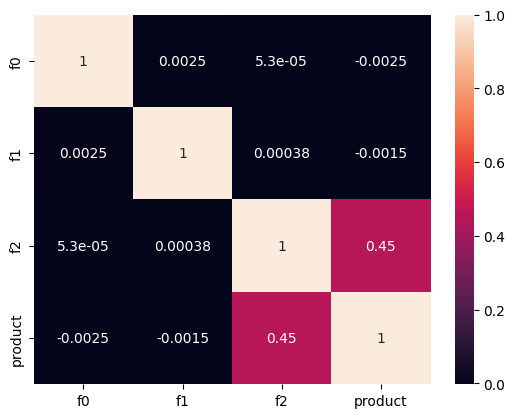

In [12]:
sns.heatmap(data2.corr(method = "spearman"), annot = True);

Есть явная взаимосвязь у объема запасов и признака f2, обратим внимание что это во втором датасете с, возможно, неточными данными.

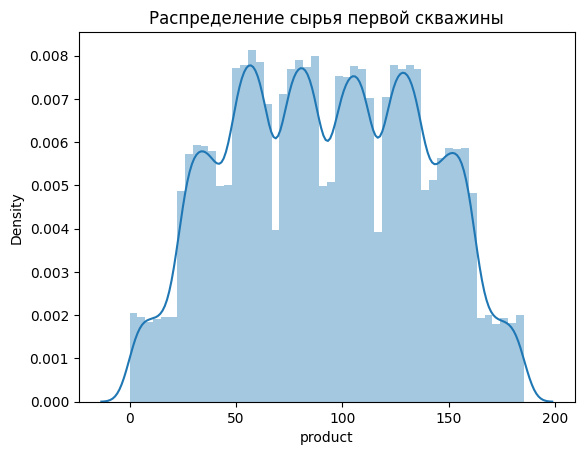

In [16]:
sns.distplot(data0['product']).set(title = 'Распределение сырья первой скважины');

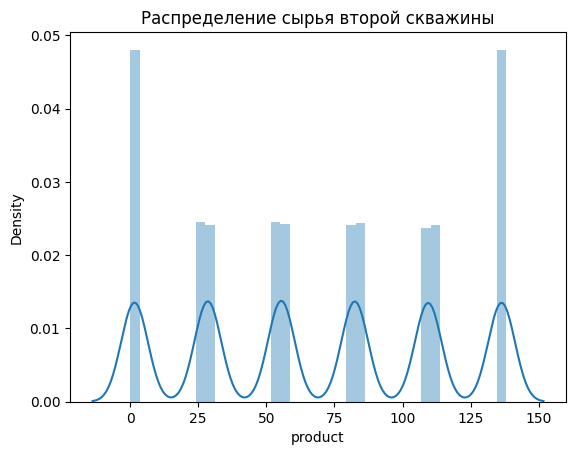

In [17]:
sns.distplot(data1['product']).set(title = 'Распределение сырья второй скважины');

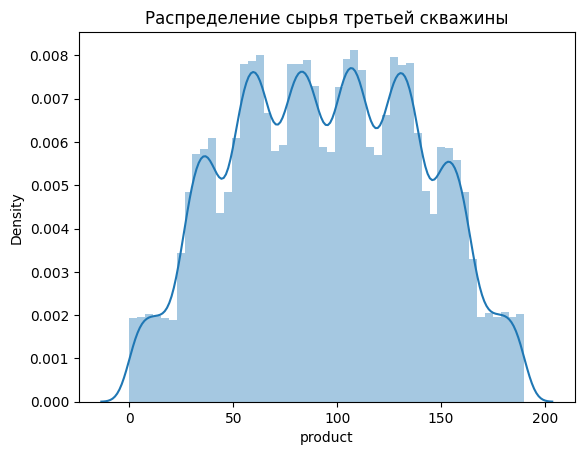

In [18]:
sns.distplot(data2['product']).set(title = 'Распределение сырья третьей скважины');

Данные в первом и третьем датасетах распределены нормально, учитывая 12 уникальных значений на 10000 строк, во втором датасете скорее всего при выгрузке информации или работе считывающего оборудования произошла ошибка/сбой.

## Обучение и проверка модели

In [19]:
def model_train(data):
    features = data.drop('product', axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size = 0.25,
                                                                                  random_state = 88)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions)**0.5
    r2 = r2_score(target_valid, predictions)
    expected_product = sum(predictions) / len(predictions)
    return target_valid, predictions, result, r2, expected_product

In [20]:
target_valid_0, predictions_0, result_0, r2_0, expected_product_0 = model_train(data0)
target_valid_1, predictions_1, result_1, r2_1, expected_product_1 = model_train(data1)
target_valid_2, predictions_2, result_2, r2_2, expected_product_2 = model_train(data2)

In [21]:
print('Cредний запас сырья 1 региона:', round(expected_product_0, 2), 'RMSE:', round(result_0, 2), 'R2:', r2_0)
print('Cредний запас сырья 2 региона:', round(expected_product_1, 2), 'RMSE:', round(result_1, 2), 'R2:', r2_1)
print('Cредний запас сырья 3 региона:', round(expected_product_2, 2), 'RMSE:', round(result_2, 2), 'R2:', r2_2)

Cредний запас сырья 1 региона: 92.62 RMSE: 37.38 R2: 0.28112028835711966
Cредний запас сырья 2 региона: 68.84 RMSE: 0.9 R2: 0.9996177237020629
Cредний запас сырья 3 региона: 95.19 RMSE: 40.16 R2: 0.19798003551876264


По первой и последней модели довольно большая ошибка (в 37 и 40 усл. единиц продукта). Следуя метрике стоит рассматривать второй регион, но там присутствует ошибка (12 уникальных значений на 10000 строк, модель могла слишиком легко обучиться и стать неточной). Рассмотрим точность предсказаний с помощью коэффициента детерминации. Наилучший коэффиицент также у второй модели.

Учитывая возможную неточность предсказаний второго региона, предпочтителен первый регион, стоит расчитать риски.


## Подготовка к расчёту прибыли

In [23]:
budget = 10000000000
all_points = 500
ml_points = 200
profit = 450000

In [24]:
one_bore = budget / ml_points
print("Цена одной скважины:", one_bore)

Цена одной скважины: 50000000.0


In [25]:
min_mean = one_bore / profit
print("Безубыточный объем:", round(min_mean, 2))

Безубыточный объем: 111.11


In [26]:
def revenues(target, predict):
    predict_sorted = predict.reset_index(drop=True).sort_values(ascending=False)
    selected_max = target.reset_index(drop=True)[predict_sorted.index][:200]
    selected_max_sum = selected_max.sum()
    if sorted(predict_sorted[:200].index) != sorted(selected_max.index):
        print("INDEX ERROR")
    return (selected_max_sum * profit) - budget

In [27]:
def series_type(target, pred):
    target = target.reset_index(drop=True)
    pred = pd.Series(pred, index = target.index)
    return target, pred

In [28]:
target_valid_0, predictions_0 = series_type(target_valid_0, predictions_0)
target_valid_1, predictions_1 = series_type(target_valid_1, predictions_1)
target_valid_2, predictions_2 = series_type(target_valid_2, predictions_2)

In [29]:
target_valid_0

0        123.801417
1         30.132880
2        157.733201
3        140.020959
4        104.368564
            ...    
24995    166.096303
24996    172.860360
24997     28.855862
24998     34.935068
24999     77.147773
Name: product, Length: 25000, dtype: float64

## Расчёт прибыли и рисков

In [39]:
def bootstrap(target, probs):
    state = np.random.RandomState(88)
    values = []
    count = 0
    for i in range(1000):
        target_sample = target.sample(n = all_points, replace = True, random_state = state)
        probs_sample = probs[target_sample.index]
        values.append(revenues(target_sample, probs_sample))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = stats.percentileofscore(values, 0)
    print('Максимальная прибыль в регионе:', values.max())
    print('Средняя прибыль в регионе:', values.mean())
    print('Минимальная прибыль в регионе:', values.min())
    print('Доверительный интервал от', lower, "до", upper)
    print('Процент риска', risk, "%")
    return

In [40]:
bootstrap(target_valid_0, predictions_0)

Максимальная прибыль в регионе: 1243532249.4154415
Средняя прибыль в регионе: 411006726.0052074
Минимальная прибыль в регионе: -384431336.090435
Доверительный интервал от -103685446.50197282 до 937573415.2938873
Процент риска 6.9 %


In [41]:
bootstrap(target_valid_1, predictions_1)

Максимальная прибыль в регионе: 1210400328.2379875
Средняя прибыль в регионе: 444999846.01543504
Минимальная прибыль в регионе: -323571956.90008736
Доверительный интервал от 48673829.55513507 до 854500657.9345086
Процент риска 2.1 %


In [42]:
bootstrap(target_valid_2, predictions_2)

Максимальная прибыль в регионе: 1133914508.2388859
Средняя прибыль в регионе: 380933963.086001
Минимальная прибыль в регионе: -474361350.6090126
Доверительный интервал от -160423805.4632148 до 898672894.952115
Процент риска 8.9 %


По процентам риска подходит только второй регион, но стоит помнить про возможную неточность при обучении на некорректных данных.

## Вывод

Рассмотрели данные по трем регионам, стоит обратить внимание на данные по второму региону, 12 уникальных значений объема на 10000 строк, возможно, часть данных была получена неверно. Пропусков не найдено.

Были построены три модели для каждого региона, наилучший результат показала модель второго региона, далее - первого.

Расчитали средний объем для безубыточной разработки в 111 у. е.. Ни один регион не подход по средним объемам для разработки.

Стоит обратить внимание на считывание данных/выгрузку данных у второго региона, возможно, при выгрузке информации или работе считывающего оборудования произошла ошибка/сбой.

Если при уточнении данных у заказчика информация по второму региону будет верна, то по предсказаниям модели и проценту возможного убытка для разработки подходит второй регион. Если данные неточны, то я бы рекомендуется пересмотреть данные(особенно по второму региону), рассмотреть предсказания снова и дать точный ответ.

Либо, следуя условию("Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.")по которому данные второго региона являются нормой, опять же предпочтителен для разработки второй регион.

На данный момент не рекомендуется никакой из регионов, так как проблемы второго описаны выше, а в первом и третьем высока вероятность убыточной разработки, стоит помнить что в каждом из регионов недостаточно среднего запаса нефти.